### How do the volumes of citations track year over year.  Since the City of Scottsdale only releases one prior year of citation data on a weekly rolling basis, I have combined the years I have downloaded so far.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
# pd.options.display.float_format = '{:.0f}'.format

In [2]:
# read in csv files
files = glob.glob('data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [3]:
# convert column labels to lower case and remove spaces from column names
def setcols(citations, fn=lambda x: x.columns.map('_'.join), cols=None):
    """ function sets the column of the data frame to the passed column list.
    """
    if cols:
        citations.columns = cols
    else:
        citations.columns = fn(citations)
    return citations

citations = citations.pipe(
        setcols,
        fn=lambda x: x.columns.str.lower()
        .str.strip()
        .str.replace(" ", "_"))

In [4]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

In [5]:
# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])

In [6]:
# combine both month and year into same column
citations['year_month'] = citations['citation_date'].apply(lambda x: str(x.year) + '.' + str(x.month).zfill(2))

In [62]:
# create month column
citations['month'] = citations['citation_date'].dt.month

# create year column
citations['year'] = citations['citation_date'].dt.year

In [12]:
# glance at the data to make sure it looks good
citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,cited_person_ethnicity,cited_person_race,cited_person_sex,city,district,officer_badge_#,state,street,street_number,zip,zone,tcmainid,year_month,month
0,97XX,12.0,Amended Charge,2074492,2018-12-20,2222,CV,Civil Traffic,"Way, Dennis",51,U,W,M,Scottsdale,D3,1476,AZ,E Sahuaro DR / N Scottsdale Rd,xxx,NaN,3003,641301,2018.12,12
1,28-701A,10.0,Speed Greater Than R&P or Posted,8093305,2018-12-20,844,CV,Civil Traffic,"Grady, Scott",61,U,W,M,Scottsdale,D3,780,AZ,N Scottsdale Rd,8xxx,NaN,2601,641302,2018.12,12
2,28-4135C,3.0,No Proof of Insurance,2076259,2018-12-18,2147,CV,Civil Traffic,"Dudgeon, Miranda",20,U,W,F,Scottsdale,D1,1509,AZ,E Osborn Rd / N Scottsdale Rd,xxx,NaN,706,641303,2018.12,12
3,28-2532A,5.0,Expired/No Arizona Registration,8093703,2018-12-21,2116,CV,Civil Traffic,"Fox, William",34,U,W,M,Scottsdale,D2,826,AZ,E Chaparral Rd / N Hayden Rd,xxx,NaN,1106,641304,2018.12,12
4,28-4135C,15.0,No Proof of Insurance,2053182,2018-12-20,2324,CV,Civil Traffic,"Rhoden, David",24,U,W,M,Scottsdale,D4,1440,AZ,E Frank Lloyd Wright Bl / N Hayden Rd,xxx,NaN,3604,641305,2018.12,12


## Graph all citations over time

In [243]:
citations.groupby('year_month')['year_month'].count().head()

year_month
2017.09     627
2017.10    2561
2017.11    2425
2017.12    2266
2018.01    2252
Name: year_month, dtype: int64

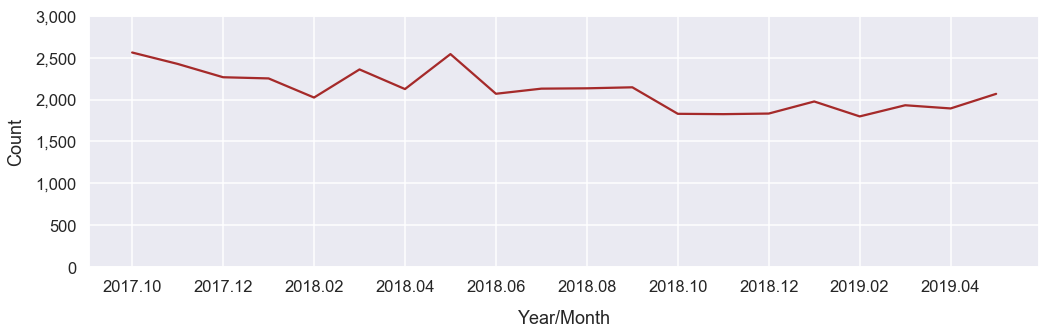

In [199]:
sns.set(rc={'figure.figsize':(15,5)})

sns.set_context('talk')
plt.tight_layout()

ax = sns.lineplot(x=citations.groupby('year_month')['year_month'].count().iloc[1:21].index, 
                  y=citations.groupby('year_month')['year_month'].count().iloc[1:21].values, 
                 color='brown')

# plt.title("xxx")
plt.ylim(0, 3000)
plt.xlabel("Year/Month", labelpad=15)
plt.ylabel("Count", labelpad=10)

ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.tight_layout()

# plt.savefig("visualizations/year_over_year.png")

## Which citations flucuate the most from month to month versus those that remain relatively constant from month to month?

In [123]:
# limit to citations with at least 50 occurences for the year
citations_more_than_50 = citations.groupby(['charge_description', 'year_month']).filter(lambda x: x['year_month'].count() >= 50)

In [126]:
charge_year = citations_more_than_50.groupby(['charge_description', 'year_month']).size()

In [127]:
charge_year.head()

charge_description                year_month
DUI-Impaired to Slightest Degree  2017.10        97
                                  2017.11        95
                                  2017.12       129
                                  2018.01        88
                                  2018.02        84
dtype: int64

In [128]:
charge_percent_month = charge_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [233]:
charge_percent_month.head()

charge_description                year_month
DUI-Impaired to Slightest Degree  2017.10       4.771274
                                  2017.11       4.672897
                                  2017.12       6.345303
                                  2018.01       4.328578
                                  2018.02       4.131825
dtype: float64

In [130]:
charge_var = charge_percent_month.groupby(level=0).apply(lambda x: x.var())

In [139]:
# which citations have the most variance?
charge_var.sort_values(ascending=False).head(5)

charge_description
Exceed 15mph In School Crossing    11.757592
Fail to Stop at Stop Sign           3.952231
Exceed Limit By More Than 20mph     2.505491
Suspended/Revoked D.L.              2.090972
No Proof of Insurance               1.735938
dtype: float64

In [235]:
# which citations have the least  variance?
charge_var.sort_values(ascending=True).head()

charge_description
Drug Paraphernalia-Possess/Use                   0.434297
Failure to Control Speed to Avoid A Collision    0.461797
Fail to Stop For Red Signal                      0.539709
Expired/No Arizona Registration                  0.555059
DUI-Impaired to Slightest Degree                 0.626316
dtype: float64

In [144]:
# subset data based on the top 5
top5_by_var = citations.loc[citations['charge_description'].isin(charge_var.sort_values(ascending=False).head(5).index)]

In [228]:
top5_by_var.groupby(['charge_description', 'year_month']).size().reset_index().sort_values(ascending=False, by='year_month').head()

,charge_description,year_month,0
106,Suspended/Revoked D.L.,2019.06,76
40,Exceed Limit By More Than 20mph,2019.06,35
84,No Proof of Insurance,2019.06,53
62,Fail to Stop at Stop Sign,2019.06,45
18,Exceed 15mph In School Crossing,2019.05,34


### Which citations with the most variance?

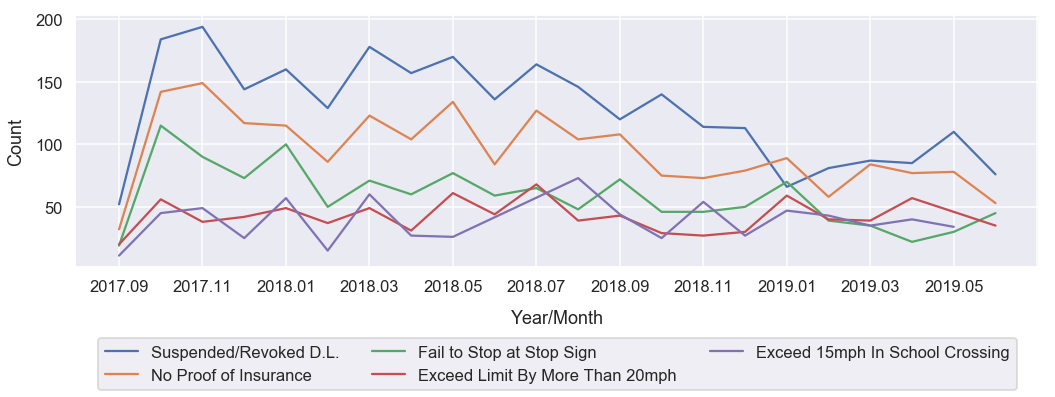

In [232]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()

sns.set_context('talk')
ax = sns.lineplot(x=top5_by_var.groupby(['year_month', 'charge_description']).size().reset_index().sort_values(ascending=False, by='year_month').iloc[:,0], 
                  y=top5_by_var.groupby(['year_month', 'charge_description']).size().reset_index().sort_values(ascending=False, by='year_month').iloc[:,2], 
                 hue=top5_by_var.groupby(['year_month', 'charge_description']).size().reset_index().sort_values(ascending=False, by='year_month').iloc[:,1],
                 sort=True)

# plt.title("xxx")

plt.xlabel("Year/Month", labelpad=15)
plt.ylabel("Count", labelpad=10)

ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)

# plt.savefig("visualizations/year_over_year.png")

Above: It's unclear to me why counts of citations start to diminish near the end of 2018

### Which citations have the least variance over time?

In [237]:
# which citations have the least  variance?
charge_var.sort_values(ascending=True).head()

charge_description
Drug Paraphernalia-Possess/Use                   0.434297
Failure to Control Speed to Avoid A Collision    0.461797
Fail to Stop For Red Signal                      0.539709
Expired/No Arizona Registration                  0.555059
DUI-Impaired to Slightest Degree                 0.626316
dtype: float64

In [238]:
# subset data based on the top 5
bottom5_by_var = citations.loc[citations['charge_description'].isin(charge_var.sort_values(ascending=True).head().index)]

In [240]:
bottom5_by_var.groupby([ 'year_month', 'charge_description']).size().reset_index().sort_values(ascending=False, by='year_month').head()

,year_month,charge_description,0
109,2019.06,Failure to Control Speed to Avoid A Collision,69
108,2019.06,Fail to Stop For Red Signal,39
107,2019.06,Expired/No Arizona Registration,110
106,2019.06,Drug Paraphernalia-Possess/Use,79
105,2019.06,DUI-Impaired to Slightest Degree,73


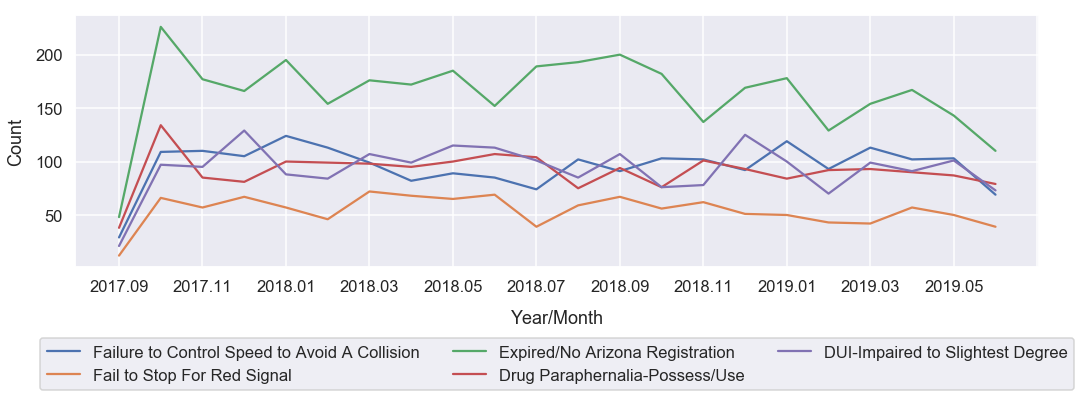

In [241]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()

sns.set_context('talk')
ax = sns.lineplot(x=bottom5_by_var.groupby([ 'year_month', 'charge_description']).size().reset_index().sort_values(ascending=False, by='year_month').iloc[:,0], 
                  y=bottom5_by_var.groupby([ 'year_month', 'charge_description']).size().reset_index().sort_values(ascending=False, by='year_month').iloc[:,2], 
                 hue=bottom5_by_var.groupby([ 'year_month', 'charge_description']).size().reset_index().sort_values(ascending=False, by='year_month').iloc[:,1],
                 sort=True)

# plt.title("xxx")

plt.xlabel("Year/Month", labelpad=15)
plt.ylabel("Count", labelpad=10)

ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)

# plt.savefig("visualizations/year_over_year.png")